In [1]:
# Import necessary library files
import pandas as pd
import numpy as np
import seaborn as sns
import math
import json
import os
import random
from matplotlib import pyplot as plt
from tqdm import tqdm

import tensorflow as tf
import tensorflow_addons as tfa
import keras.backend as K

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [2]:
# Set seeds for reproducibility
def seed_everwhere(seed = 4816):
    os.environ['PYTHONHASHSEED']=str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    

seed_everwhere()

In [3]:
# Load data directly from Kaggle
train = pd.read_json('../input/stanford-covid-vaccine/train.json', lines=True)
test = pd.read_json('../input/stanford-covid-vaccine/test.json', lines=True)
sample_sub = pd.read_csv('../input/stanford-covid-vaccine/sample_submission.csv')

# Processing input
Three string inputs and two floating point arrays as features.

In [4]:
# Feature Engineering
# It uses the BPPS (one for each molecules) and
# Generates three different columns title bpps_sum, bpps_max and bpps_np.
# Each of these columns are arry of floating point numbers of size sequence_length.


# The function reads each BPPS file and
# Generates a array of floating point number (by column wise) summing up the matrix.
def read_bpps_sum(df):
    bpps_arr = []
    for mol_id in df.id.to_list():
        bpps_arr.append(np.load(f"../input/stanford-covid-vaccine/bpps/{mol_id}.npy").sum(axis=1))
    return bpps_arr


# The function reads each BPPS file and
# Generates a array of floating point number (by) taking (column wise) maximum of the matrix.
def read_bpps_max(df):
    bpps_arr = []
    for mol_id in df.id.to_list():
        bpps_arr.append(np.load(f"../input/stanford-covid-vaccine/bpps/{mol_id}.npy").max(axis=1))
    return bpps_arr


# The function reads each BPPS file and
# Generates a array of floating point number calculating z-scores (column wise) from the matrix.
def read_bpps_nb(df):
    #mean and std from https://www.kaggle.com/symyksr/openvaccine-deepergcn 
    bpps_nb_mean = 0.077522
    bpps_nb_std = 0.08914
    bpps_arr = []
    for mol_id in df.id.to_list():
        bpps = np.load(f"../input/stanford-covid-vaccine/bpps/{mol_id}.npy")
        bpps_nb = (bpps > 0).sum(axis=0) / bpps.shape[0]
        bpps_nb = (bpps_nb - bpps_nb_mean) / bpps_nb_std
        bpps_arr.append(bpps_nb)
    return bpps_arr 


# Extend the training and testing datasets with bpps_sum, bpps_max and bpps_nb columns
train['bpps_sum'] = read_bpps_sum(train)
test['bpps_sum'] = read_bpps_sum(test)
train['bpps_max'] = read_bpps_max(train)
test['bpps_max'] = read_bpps_max(test)
train['bpps_nb'] = read_bpps_nb(train)
test['bpps_nb'] = read_bpps_nb(test)

In [5]:
# Output column list
target_cols = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']

# Transfering tokens to unique integers.
# Sequence tokens: 'A', 'C', 'U', 'G'
# Structure tokens: '()', ')', '.'
# Predicted loop type tokens: 'B', 'E', 'H', 'I', 'M', 'S', 'X'
# Total 14 tokens.
token2int = {x:i for i, x in enumerate('().ACGUBEHIMSX')}

In [6]:
# Preparing Input.
# Transferring string to list of tokens.
# Transferring array of flotting point number to list of floating point number.
def preprocess_inputs(df, cols=['sequence', 'structure', 'predicted_loop_type']):
    base_fea = np.transpose(
        np.array(
            df[cols]
            .applymap(lambda seq: [token2int[x] for x in seq])
            .values
            .tolist()
        ),
        (0, 2, 1)
    )
    bpps_sum_fea = np.array(df['bpps_sum'].to_list())[:,:,np.newaxis]
    bpps_max_fea = np.array(df['bpps_max'].to_list())[:,:,np.newaxis]
    return np.concatenate([base_fea,bpps_sum_fea,bpps_max_fea], 2)

# Defining Model
Loss functions: RMSE and MC-RMSE
Two different models: one with GRU and the other with LSTM

In [7]:
# https://www.kaggle.com/c/stanford-covid-vaccine/discussion/183211

# This is regular root mean square loss function.
def rmse(y_actual, y_pred):
    mse = tf.keras.losses.mean_squared_error(y_actual, y_pred)
    return K.sqrt(mse)


# This is the competition's official loss function, MC-RMSE.
# MC-RMSE = Mean Colunm - Root Mean Square function.
def mcrmse(y_actual, y_pred, num_scored=len(target_cols)):
    score = 0
    for i in range(num_scored):
        score += rmse(y_actual[:, :, i], y_pred[:, :, i]) / num_scored
    return score

In [8]:
# We used bidirectional GRU layer in our architecture.
# There are three such layers in our model.
def gru_layer(hidden_dim, dropout):
    return tf.keras.layers.Bidirectional(
                                tf.keras.layers.GRU(hidden_dim,
                                dropout=dropout,
                                return_sequences=True,
                                kernel_initializer='orthogonal'))


# We used bidirectional LSTM layer in our architecture.
# There are one such layers in our model.
def lstm_layer(hidden_dim, dropout):
    return tf.keras.layers.Bidirectional(
                                tf.keras.layers.LSTM(hidden_dim,
                                dropout=dropout,
                                return_sequences=True,
                                kernel_initializer='orthogonal'))



def build_model(rnn='gru', convolve=False, conv_dim=512, 
                dropout=.4, sp_dropout=.2, embed_dim=100,
                hidden_dim=256, layers=3,
                seq_len=107, pred_len=68):
    
    # Input dimension and processing
    inputs = tf.keras.layers.Input(shape=(seq_len, 5))
    categorical_feats = inputs[:, :, :3]
    numerical_feats = inputs[:, :, 3:]
    
    # Embedding dimension and processing
    embed = tf.keras.layers.Embedding(input_dim=len(token2int),
                                      output_dim=embed_dim)(categorical_feats)
    reshaped = tf.reshape(
        embed, shape=(-1, embed.shape[1],  embed.shape[2] * embed.shape[3]))
    
    reshaped = tf.keras.layers.concatenate([reshaped, numerical_feats], axis=2)
    hidden = tf.keras.layers.SpatialDropout1D(sp_dropout)(reshaped)
    
    # In the model definition we have convolve layer.
    # However, in our architecture, we did not used any convolution layer (i.e., convolve=False)
    if convolve:
        hidden = tf.keras.layers.Conv1D(conv_dim, 5, padding='same', activation=tf.keras.activations.swish)(hidden)


    # RNN layer using the above defined functions (gru_layer and lstm_layer).
    if rnn is 'gru':
        for _ in range(layers):
            hidden = gru_layer(hidden_dim, dropout)(hidden)
        
    elif rnn is 'lstm':
        for _ in range(layers):
            hidden = lstm_layer(hidden_dim, dropout)(hidden)

    # Output
    # for traning and public testing data, predicted_length = 68
    # for private testing data, predicted_length = 91
    out = hidden[:, :pred_len]
    out = tf.keras.layers.Dense(5, activation='linear')(out)
    
    model = tf.keras.Model(inputs=inputs, outputs=out)
    # Optimizer: Adam
    adam = tf.optimizers.Adam()
    # Loss function: MC-RMSE
    model.compile(optimizer=adam, loss=mcrmse)

    return model

# KFold Training, Validation and Testing
Actually 2-fold cross validation for quick execution.

In [9]:
def train_and_infer(rnn, STRATIFY=False, FOLDS=2, EPOCHS=100, BATCH_SIZE=64,
                    REPEATS=1, SEED=4816, VERBOSE=2):

    #get test now for OOF 
    public_df = test.query("seq_length == 107").copy()
    private_df = test.query("seq_length == 130").copy()
    private_preds = np.zeros((private_df.shape[0], 130, 5))
    public_preds = np.zeros((public_df.shape[0], 107, 5))
    public_inputs = preprocess_inputs(public_df)
    private_inputs = preprocess_inputs(private_df)

    #to evaluate TTA effects/post processing
    holdouts = []
    holdout_preds = []
    
    #to view learning curves
    histories = []
    
    #put similar RNA in the same fold
    gkf = GroupKFold(n_splits=FOLDS)
    kf=KFold(n_splits=FOLDS, random_state=SEED)
    kmeans_model = KMeans(n_clusters=200, random_state=SEED).fit(preprocess_inputs(train)[:,:,0])
    train['cluster_id'] = kmeans_model.labels_

    for _ in range(REPEATS):
        
        for f, (train_index, val_index) in enumerate((gkf if STRATIFY else kf).split(train,
                train['reactivity'], train['cluster_id'] if STRATIFY else None)):

            # Define callback function to manipulate the learning rate
            lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience=8, 
                                                               factor=.1,
                                                               #min_lr=1e-5,
                                                               verbose=VERBOSE)
            # Define callback function to save the best model parameters
            save = tf.keras.callbacks.ModelCheckpoint(f'model-{f}.h5')

            # Define sample weight function
            epsilon = .1
            sample_weighting = np.log1p(train.iloc[train_index]['signal_to_noise'] + epsilon) / 2

            # Get training and validation dataset
            # Get training dataset
            trn = train.iloc[train_index]
            trn_ = preprocess_inputs(trn)
            trn_labs = np.array(trn[target_cols].values.tolist()).transpose((0, 2, 1))

            # Get validation dataset
            val = train.iloc[val_index]
            val_all = preprocess_inputs(val)
            val = val[val.SN_filter == 1]
            val_ = preprocess_inputs(val)
            val_labs = np.array(val[target_cols].values.tolist()).transpose((0, 2, 1))

            # Instantiate the model (i.e., pre-build model) for different sequence lengths
            model = build_model(rnn=rnn)
            model_short = build_model(rnn=rnn,seq_len=107, pred_len=107)
            model_long = build_model(rnn=rnn,seq_len=130, pred_len=130)

            # Train the model
            history = model.fit(
                trn_, trn_labs,
                validation_data = (val_, val_labs),
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                sample_weight=sample_weighting,
                callbacks=[save, lr_callback],
                verbose=VERBOSE
            )

            histories.append(history)

            #load best models
            model.load_weights(f'model-{f}.h5')
            model_short.load_weights(f'model-{f}.h5')
            model_long.load_weights(f'model-{f}.h5')

            holdouts.append(train.iloc[val_index])
            holdout_preds.append(model.predict(val_all))

            public_preds += model_short.predict(public_inputs) / (FOLDS * REPEATS)
            private_preds += model_long.predict(private_inputs) / (FOLDS * REPEATS)
        
        del model, model_short, model_long
        
    return holdouts, holdout_preds, public_df, public_preds, private_df, private_preds, histories

### GRU training and prediction.

In [10]:
gru_holdouts, gru_holdout_preds, public_df, gru_public_preds, private_df, gru_private_preds, gru_histories = train_and_infer(rnn='gru')

Epoch 1/100
19/19 - 4s - loss: 0.3792 - val_loss: 0.3921
Epoch 2/100
19/19 - 2s - loss: 0.3219 - val_loss: 0.3673
Epoch 3/100
19/19 - 2s - loss: 0.3087 - val_loss: 0.3552
Epoch 4/100
19/19 - 2s - loss: 0.2973 - val_loss: 0.3367
Epoch 5/100
19/19 - 2s - loss: 0.2879 - val_loss: 0.3255
Epoch 6/100
19/19 - 2s - loss: 0.2786 - val_loss: 0.3141
Epoch 7/100
19/19 - 2s - loss: 0.2756 - val_loss: 0.3114
Epoch 8/100
19/19 - 2s - loss: 0.2705 - val_loss: 0.3086
Epoch 9/100
19/19 - 2s - loss: 0.2663 - val_loss: 0.3025
Epoch 10/100
19/19 - 2s - loss: 0.2631 - val_loss: 0.2999
Epoch 11/100
19/19 - 2s - loss: 0.2601 - val_loss: 0.2971
Epoch 12/100
19/19 - 2s - loss: 0.2572 - val_loss: 0.2893
Epoch 13/100
19/19 - 2s - loss: 0.2532 - val_loss: 0.2834
Epoch 14/100
19/19 - 2s - loss: 0.2482 - val_loss: 0.2808
Epoch 15/100
19/19 - 2s - loss: 0.2471 - val_loss: 0.2785
Epoch 16/100
19/19 - 2s - loss: 0.2438 - val_loss: 0.2711
Epoch 17/100
19/19 - 2s - loss: 0.2382 - val_loss: 0.2674
Epoch 18/100
19/19 - 2s

Epoch 40/100
19/19 - 2s - loss: 0.1819 - val_loss: 0.2259
Epoch 41/100
19/19 - 2s - loss: 0.1800 - val_loss: 0.2283
Epoch 42/100
19/19 - 2s - loss: 0.1791 - val_loss: 0.2327
Epoch 43/100
19/19 - 2s - loss: 0.1766 - val_loss: 0.2257
Epoch 44/100
19/19 - 2s - loss: 0.1761 - val_loss: 0.2288
Epoch 45/100
19/19 - 2s - loss: 0.1744 - val_loss: 0.2249
Epoch 46/100
19/19 - 2s - loss: 0.1723 - val_loss: 0.2256
Epoch 47/100
19/19 - 2s - loss: 0.1712 - val_loss: 0.2260
Epoch 48/100
19/19 - 2s - loss: 0.1694 - val_loss: 0.2237
Epoch 49/100
19/19 - 2s - loss: 0.1682 - val_loss: 0.2268
Epoch 50/100
19/19 - 2s - loss: 0.1671 - val_loss: 0.2237
Epoch 51/100
19/19 - 2s - loss: 0.1664 - val_loss: 0.2235
Epoch 52/100
19/19 - 2s - loss: 0.1650 - val_loss: 0.2234
Epoch 53/100
19/19 - 2s - loss: 0.1631 - val_loss: 0.2244
Epoch 54/100
19/19 - 2s - loss: 0.1619 - val_loss: 0.2206
Epoch 55/100
19/19 - 2s - loss: 0.1609 - val_loss: 0.2223
Epoch 56/100
19/19 - 2s - loss: 0.1594 - val_loss: 0.2245
Epoch 57/100
1

### LSTM training and prediction.

In [11]:
lstm_holdouts, lstm_holdout_preds, public_df, lstm_public_preds, private_df, lstm_private_preds, lstm_histories = train_and_infer(rnn='lstm')

Epoch 1/100
19/19 - 5s - loss: 0.4022 - val_loss: 0.4155
Epoch 2/100
19/19 - 2s - loss: 0.3310 - val_loss: 0.3812
Epoch 3/100
19/19 - 2s - loss: 0.3110 - val_loss: 0.3583
Epoch 4/100
19/19 - 2s - loss: 0.3001 - val_loss: 0.3465
Epoch 5/100
19/19 - 2s - loss: 0.2916 - val_loss: 0.3339
Epoch 6/100
19/19 - 2s - loss: 0.2829 - val_loss: 0.3212
Epoch 7/100
19/19 - 2s - loss: 0.2779 - val_loss: 0.3187
Epoch 8/100
19/19 - 2s - loss: 0.2729 - val_loss: 0.3132
Epoch 9/100
19/19 - 2s - loss: 0.2697 - val_loss: 0.3055
Epoch 10/100
19/19 - 2s - loss: 0.2641 - val_loss: 0.3004
Epoch 11/100
19/19 - 2s - loss: 0.2603 - val_loss: 0.2938
Epoch 12/100
19/19 - 2s - loss: 0.2570 - val_loss: 0.2912
Epoch 13/100
19/19 - 2s - loss: 0.2530 - val_loss: 0.2866
Epoch 14/100
19/19 - 2s - loss: 0.2491 - val_loss: 0.2851
Epoch 15/100
19/19 - 2s - loss: 0.2476 - val_loss: 0.2847
Epoch 16/100
19/19 - 2s - loss: 0.2442 - val_loss: 0.2773
Epoch 17/100
19/19 - 2s - loss: 0.2398 - val_loss: 0.2741
Epoch 18/100
19/19 - 2s

Epoch 37/100
19/19 - 2s - loss: 0.1788 - val_loss: 0.2294
Epoch 38/100
19/19 - 2s - loss: 0.1761 - val_loss: 0.2269
Epoch 39/100
19/19 - 2s - loss: 0.1742 - val_loss: 0.2264
Epoch 40/100
19/19 - 2s - loss: 0.1714 - val_loss: 0.2276
Epoch 41/100
19/19 - 2s - loss: 0.1699 - val_loss: 0.2255
Epoch 42/100
19/19 - 2s - loss: 0.1681 - val_loss: 0.2275
Epoch 43/100
19/19 - 2s - loss: 0.1661 - val_loss: 0.2256
Epoch 44/100
19/19 - 2s - loss: 0.1641 - val_loss: 0.2259
Epoch 45/100
19/19 - 2s - loss: 0.1623 - val_loss: 0.2245
Epoch 46/100
19/19 - 2s - loss: 0.1610 - val_loss: 0.2242
Epoch 47/100
19/19 - 2s - loss: 0.1592 - val_loss: 0.2254
Epoch 48/100
19/19 - 2s - loss: 0.1584 - val_loss: 0.2254
Epoch 49/100
19/19 - 3s - loss: 0.1566 - val_loss: 0.2237
Epoch 50/100
19/19 - 2s - loss: 0.1548 - val_loss: 0.2233
Epoch 51/100
19/19 - 2s - loss: 0.1545 - val_loss: 0.2233
Epoch 52/100
19/19 - 2s - loss: 0.1534 - val_loss: 0.2234
Epoch 53/100
19/19 - 2s - loss: 0.1511 - val_loss: 0.2209
Epoch 54/100
1

# Drawing loss against epoch curve
#### Both for training and validation dataset

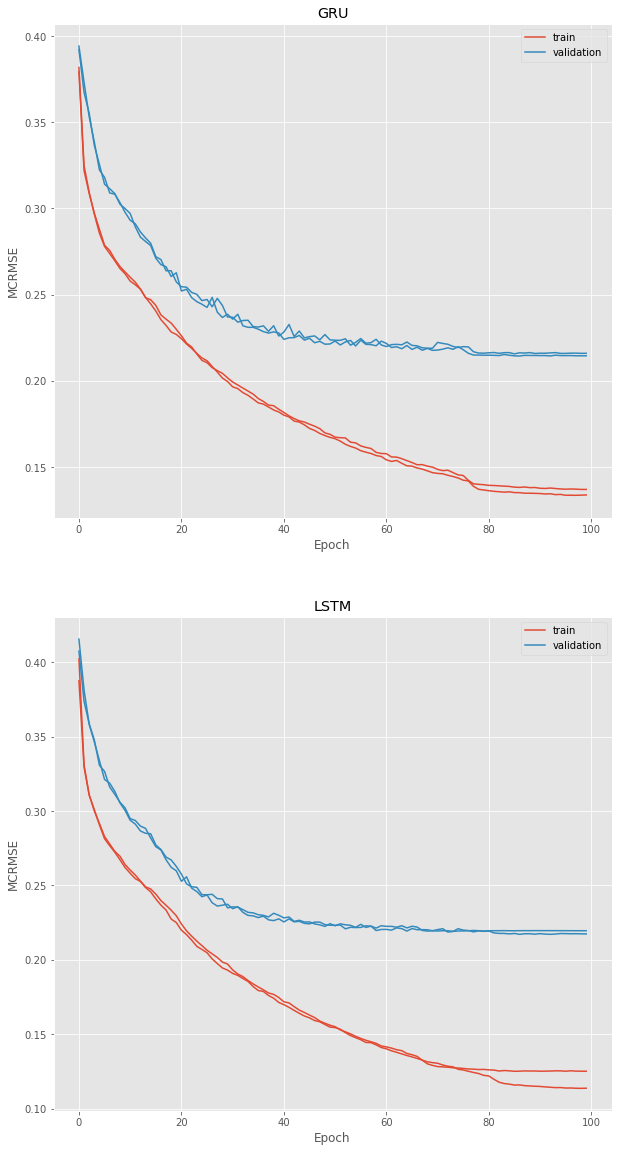

In [12]:
def plot_learning_curves(results):
    plt.style.use('ggplot')
    fig, ax = plt.subplots(len(results['histories']), 1, figsize = (10, 20))
    for i, result in enumerate(results['histories']):
        for history in result:
            ax[i].plot(history.history['loss'], color='C0')
            ax[i].plot(history.history['val_loss'], color='C1')
            ax[i].set_title(f"{results['models'][i]}")
            ax[i].set_ylabel('MCRMSE')
            ax[i].set_xlabel('Epoch')
            ax[i].legend(['train', 'validation'], loc = 'upper right')
            
results = {
            "models" : ['GRU', 'LSTM'],    
            "histories" : [gru_histories, lstm_histories],
            }



plot_learning_curves(results)

In [13]:
def format_predictions(test_df, test_preds, val=False):
    preds = []
    
    for df, preds_ in zip(test_df, test_preds):
        for i, uid in enumerate(df['id']):
            single_pred = preds_[i]

            single_df = pd.DataFrame(single_pred, columns=target_cols)
            single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]
            if val: single_df['SN_filter'] = df[df['id'] == uid].SN_filter.values[0]

            preds.append(single_df)
    return pd.concat(preds)

# Preparing submission file

In [14]:
# Combining public and private dataset
gru_preds = [gru_public_preds, gru_private_preds]
lstm_preds = [gru_public_preds, gru_private_preds]
test_df = [public_df, private_df]
gru_preds = format_predictions(test_df, gru_preds)
lstm_preds = format_predictions(test_df, lstm_preds)

In [15]:
# Averaging GRU and LSTM predictions with equal percentage
gru_weight = .5
lstm_weight = .5

blended_preds = pd.DataFrame()
blended_preds['id_seqpos'] = gru_preds['id_seqpos']
blended_preds['reactivity'] = gru_weight*gru_preds['reactivity'] + lstm_weight*lstm_preds['reactivity']
blended_preds['deg_Mg_pH10'] = gru_weight*gru_preds['deg_Mg_pH10'] + lstm_weight*lstm_preds['deg_Mg_pH10']
blended_preds['deg_pH10'] = gru_weight*gru_preds['deg_pH10'] + lstm_weight*lstm_preds['deg_pH10']
blended_preds['deg_Mg_50C'] = gru_weight*gru_preds['deg_Mg_50C'] + lstm_weight*lstm_preds['deg_Mg_50C']
blended_preds['deg_50C'] = gru_weight*gru_preds['deg_50C'] + lstm_weight*lstm_preds['deg_50C']

In [16]:
# Dumping output files
submission = sample_sub[['id_seqpos']].merge(blended_preds, on=['id_seqpos'])
submission.to_csv(f'submission_manazir.csv', index=False)